# Second step in pipeline
## Implement modified TopicTiling Algorithm (Riedl, Biemann, 2012) adjusted for HDBSCAN topic probaiblity vectors

In [1]:
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
# Functions for segmentation. Segmentation main call function calls all of the above. 

def smoothing(topic_proba_df, threshold):
    """Take the df and output new df with smoothed_topic_probs column 
        threshold (float): all probabilities under the thresold will be set to 0.    
    """
    smoothed_topic_proabilities_ls = []

    for i in range(len(topic_proba_df)):
        smoothed_topic_proabilities = np.array(topic_proba_df.topic_probs[i])
        smoothed_topic_proabilities[smoothed_topic_proabilities < threshold] = 0
        smoothed_topic_proabilities_ls.append(smoothed_topic_proabilities)
    topic_proba_df['smoothed_topic_probabilities'] = smoothed_topic_proabilities_ls

    return topic_proba_df


def window_cosine_sim(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = []

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.smoothed_topic_probabilities[p-window_size:p]
        w_r = dataframe.smoothed_topic_probabilities[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas, distance = 3 since the smallest segment in our annotations is 3 sentences
    minimas, _ = find_peaks(window_cosines_neg, distance=3, width=2, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p-1, 0, -1):
        try: # handle control flow for the first 10 values in cos_sims
            max_found_in_slice = cos_sims[i-side_check_range: i].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p+1, len(cos_sims)):
        try: # handle control flow for the last 10 values in cos_sims
            max_found_in_slice = cos_sims[i: i+side_check_range].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
              break
    
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3, smooting_threshold=1e-20):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    smoothed_probability_df = smoothing(dataframe, smooting_threshold)
    window_cosines = window_cosine_sim(smoothed_probability_df, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds


def get_depth_scores(dataframe, print_state_min, height=0.995, window=3, smooting_threshold=1e-20):
    """Subset of the functions used in segmentation_main_call"""
    smoothed_probability_df = smoothing(dataframe, smooting_threshold)
    window_cosines = window_cosine_sim(smoothed_probability_df, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    return ds


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    plt.figure(figsize=(6, 4.5))
    
    ax = sns.lineplot(cosine_similarities_for_windows)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=len(cosine_similarities_for_windows))
    ax.set_xlabel("p\npredicted segment breaks marked in red")
    ax.set_ylabel("Cosine similarity")
    if boundaries != None:
        boundaries_np = np.array(boundaries) - window_size
        ax = sns.scatterplot(x=boundaries_np, y=cosine_similarities_for_windows[boundaries_np], marker="x", linewidth=2, color='r')

    ax.set_title(f"Cos. Sim. Over Transcript Windows [win. size: {window_size}]")
    plt.show()


def close_match(actual_breaks, predicted_breaks, close_definition=3): 
    """
    Find close matches between actual and predicted breaks. Returns accuracy, actual number of close matches and the positions of the close matches.
    actual_breaks: set of actual breaks
    predicted_breaks: set of predicted breaks
    close_definition: int, how many sentences a segment break can be away from the actual break to count as close. 
    """
    s = predicted_breaks.copy()
    new_set = set()
    for element in s:
        for i in range(1, close_definition+1): 
            new_set.add(element-i)
            new_set.add(element+i)
    s.update(new_set)

    intersection_actual_pred = actual_breaks.intersection(s)
    return (len(intersection_actual_pred)/len(actual_breaks)), len(intersection_actual_pred), intersection_actual_pred

## Pipeline step 2

In [ ]:
# Try out different hyperparameter settings and get KPIs for all 20 annotated transcripts
actual = pd.read_pickle('annotations.pkl')

# walk directory to loop through files
for dirpath, _, files in os.walk('../Thesis/annotated_probabilities_msize200'):
    
    # initialise lists for appending scores
    episode = []; actual_breaks = []; predicted_breaks = []; exact_matches = []
    close_matches = []; accuracy = []; window_param = []; height_param = []; len_of_transcript = []; window_diff_ls = []

    # For each file, get KPIs for different hyperparameter settings and add to lists
    for file in files:
        eps_id = file[:-4].split('_')[4]
        path = os.path.join(dirpath, file)
        topic_proba_dens_vector = np.load(path)
        vector_length = len(topic_proba_dens_vector)
        annotated_probabilities_df = pd.DataFrame({"sentence_no":[i for i in range(vector_length)],
                                                    "topic_probs": topic_proba_dens_vector.tolist()})

        # get predicted bounds
        # he = [0.99, 0.95, 0.9]
        # for h in he:
        h=0.95
        for win in range(2, 41, 2):
            if win*2 >= len(annotated_probabilities_df.index):
                print(win)
                break
            else:
                predicted_bounds = segmentation_main_call(annotated_probabilities_df,\
                                                            print_state_min=False,\
                                                            print_state_depth=False,\
                                                            window=win, height=0.95)
                predicted_bounds_set = set(predicted_bounds)

                # get actual bounds
                actual_bounds = actual[actual.episode_id == eps_id].iloc[0,2]

                # get exact and close matches
                actual_bounds_set = set(actual_bounds)
                
                acc, num_matches, list = close_match(actual_bounds_set, predicted_bounds_set, close_definition=5)
                
                # Append to build dataframe downstream
                episode.append(eps_id)
                actual_breaks.append(len(actual_bounds_set))
                predicted_breaks.append(len(predicted_bounds))
                exact_matches.append(len(predicted_bounds_set.intersection(actual_bounds_set)))
                close_matches.append(num_matches)
                accuracy.append(acc)
                window_param.append(win)
                height_param.append(h)
                len_of_transcript.append(vector_length)

                # window diff, k = window size
                k = 4
                window_diff_unnormalised = 0
                for i in range(vector_length - k):
                    sliding_window = set([w for w in range(i, i + k, 1)])
                    actual_in_sliding_window = len(actual_bounds_set.intersection(sliding_window)) # ref
                    predicted_in_sliding_window = len(predicted_bounds_set.intersection(sliding_window)) # hyp
                    window_diff_absolute = np.abs(actual_in_sliding_window - predicted_in_sliding_window)
                    window_diff_unnormalised += window_diff_absolute
                window_diff = (1/(vector_length-k)) * window_diff_unnormalised
                window_diff_ls.append(window_diff)
        print(eps_id, 'done')

        
    # Create dataframe with all figures for comparison
    evaluation_df = pd.DataFrame({'episode': episode,
                                  'actual_breaks': actual_breaks,
                                  'predicted_breaks': predicted_breaks,
                                  'exact_matches': exact_matches,
                                  'close_matches': close_matches,
                                  'window_diff': window_diff_ls,
                                  'accuracy_close_match': accuracy,
                                  'window_size': window_param,
                                  'height': height_param,
                                  'len_of_transcript': len_of_transcript})

print(evaluation_df.shape)

In [166]:
evaluation_df.to_csv('../Thesis/evaluation/evaluation_200.csv')

In [ ]:
# TP: close_matches
# FP: predicted breaks - close matches
# FN: actual breaks - close matches
# TN: transcript_len - predicted breaks - actual breaks + close matches

## Add evaluation metrics 
# evaluation_df['true_positives'] = evaluation_df.close_matches
# evaluation_df['false_positives'] = evaluation_df.predicted_breaks - evaluation_df.close_matches
# evaluation_df['false_negatives'] = evaluation_df.actual_breaks - evaluation_df.close_matches
# evaluation_df['true_negatives'] = evaluation_df.len_of_transcript - evaluation_df.predicted_breaks - evaluation_df.actual_breaks + evaluation_df.close_matches
# evaluation_df['precision'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_positives)
# evaluation_df['recall'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_negatives)
# evaluation_df['F1'] = evaluation_df.true_positives / (evaluation_df.true_positives + 0.5*(evaluation_df.false_positives + evaluation_df.false_negatives))
evaluation_df.loc[0:50]

### Visualise results

In [13]:
# evaluation_df = pd.read_csv('../Thesis/evaluation/evaluation_15.csv')

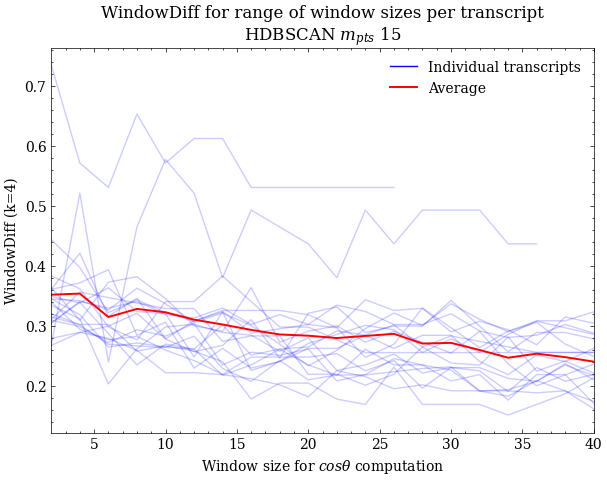

In [14]:
# Plot evaluation metric over different k for each annotated transcript
plt.style.use(['science','no-latex'])
grouped_df = evaluation_df.groupby('window_size')[['window_diff']].mean()  # get average

figure(figsize=(7, 5))
palette = sns.color_palette(['blue'], 20)
ax1 = sns.lineplot(evaluation_df, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2)
ax2 = sns.lineplot(data = grouped_df, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4)
current_handles, current_labels = plt.gca().get_legend_handles_labels()  # get legend obejcts 
plt.legend(current_handles[-2:], ['Individual transcripts','Average'])  # modify legend
plt.xlim(min(evaluation_df.window_size), max(evaluation_df.window_size))
# plt.ylim(0.03, 0.19)
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('WindowDiff for range of window sizes per transcript\nHDBSCAN $m_{pts}$ 15')
plt.show()

In [3]:
# DFs for plot below
eval15 = pd.read_csv('../Thesis/evaluation/evaluation_15.csv')
eval50 = pd.read_csv('../Thesis/evaluation/evaluation_50.csv')
eval200 = pd.read_csv('../Thesis/evaluation/evaluation_200.csv')

grouped_15 = eval15.groupby('window_size')[['window_diff']].mean()  # get average
grouped_50 = eval50.groupby('window_size')[['window_diff']].mean()  # get average
grouped_200 = eval200.groupby('window_size')[['window_diff']].mean()  # get average

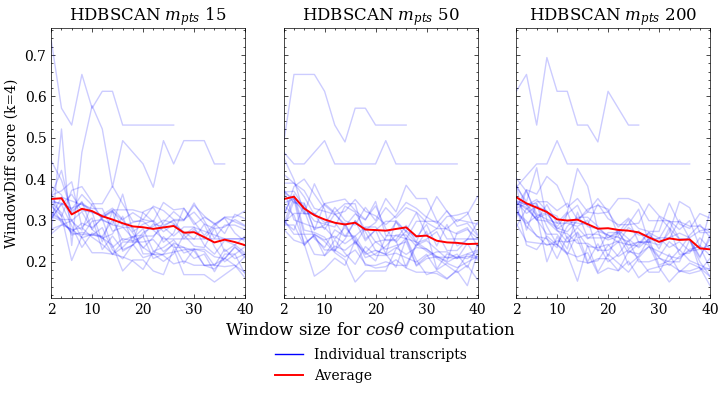

In [16]:
# Plot evaluation metric over different windowsize for each annotated transcript
plt.style.use(['science','no-latex'])
fig, axs = plt.subplots(1,3, figsize=(8.5, 3.5), sharey=True)
palette = sns.color_palette(['blue'], 20)

ax1 = sns.lineplot(data=eval15, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[0])
ax2 = sns.lineplot(data = grouped_15, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[0])
ax3 = sns.lineplot(data=eval50, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[1])
ax4 = sns.lineplot(data = grouped_50, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[1])
ax5 = sns.lineplot(data=eval200, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2, ax=axs[2])
ax6 = sns.lineplot(data = grouped_200, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4, ax=axs[2])

# modify legend
axs[0].get_legend().remove()
axs[2].get_legend().remove()
current_handles, current_labels = plt.gca().get_legend_handles_labels()  
axs[1].legend(current_handles[-2:], ['Individual transcripts','Average'], loc='lower center', bbox_to_anchor=(0.45, -0.36))

axs[0].set_title('HDBSCAN $m_{pts}$ 15')
axs[1].set_title('HDBSCAN $m_{pts}$ 50')
axs[2].set_title('HDBSCAN $m_{pts}$ 200')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
fig.supxlabel(r'Window size for $cos \theta$ computation', y=-0.012)

axs[0].set_xlim(min(eval15.window_size), max(eval15.window_size))
axs[1].set_xlim(min(eval50.window_size), max(eval50.window_size))
axs[2].set_xlim(min(eval200.window_size), max(eval200.window_size))

axs[0].set_xticks([2,10,20,30,40])
axs[1].set_xticks([2,10,20,30,40])
axs[2].set_xticks([2,10,20,30,40])

axs[0].set_ylabel('WindowDiff score (k=4)')

plt.show()

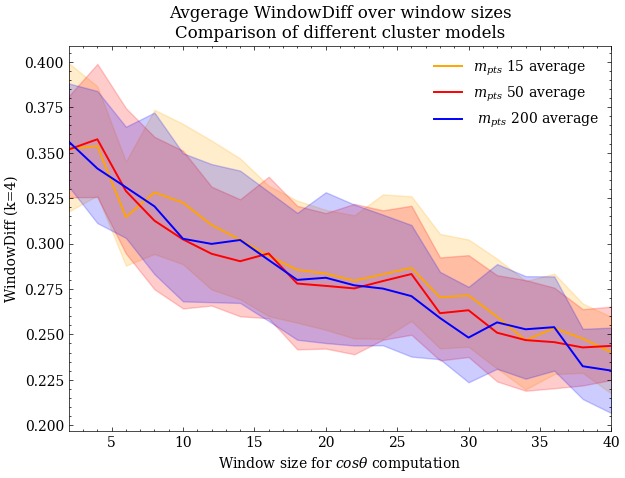

In [7]:
# plot all averages
plt.style.use(['science','no-latex'])
figure(figsize=(7, 5))

ax1 = sns.lineplot(data = eval15, x='window_size', y='window_diff', color='orange', alpha=1, label='$m_{pts}$ 15 average', linewidth=1.4)
ax2 = sns.lineplot(data = eval50, x='window_size', y='window_diff', color='red', alpha=1, label='$m_{pts}$ 50 average', linewidth=1.4)
ax3 = sns.lineplot(data = eval200, x='window_size', y='window_diff', color='blue', alpha=1, label=' $m_{pts}$ 200 average', linewidth=1.4)

plt.xlim(min(eval15.window_size), max(eval15.window_size))
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('Avgerage WindowDiff over window sizes\nComparison of different cluster models')
plt.show()

In [11]:
# Average WindowDiff accross w
print(f'Average wd, 15: {eval15.window_diff.mean():.4f}')
print(f'Average wd, 50: {eval50.window_diff.mean():.4f}')
print(f'Average wd, 200: {eval200.window_diff.mean():.4f}')


Average wd, 15: 0.2900
Average wd, 50: 0.2848
Average wd, 200: 0.2840


### Get boundaries of transcript to feed to next stage

In [ ]:
# Get boudaries for specific transcript to feed to next stage

# input
# hdbscan_model_number = 200
# transcript_ref = '13NDTKL5ZGs8cb8dojW3bz'

model_list = [15, 50, 200]
transcript_list = ['13NDTKL5ZGs8cb8dojW3bz', '6preEOWrgR9eRr938upFgv',
       '2Bp5vd9GAmEpZzjEtGQBFD', '0ZGQ63222rqX5TD5ZrMmcN',
       '19W5dgUcFseQZBmcVF4coc', '3iydyD9rAb1f6rmvmgpwS4',
       '0bXWB28GwN8OiqC1ykRrRX', '28IWswylk2FvkebOehoCkL',
       '3DR5Qa40Mc17AiBYfmC29U', '3RT2j2BG8ILNYKjxsNhfvZ',
       '3p9FLEH5V5sCGHhGubaYZc', '5Sg6efUjypR4m6p9eYBXpm',
       '4y67J0Fmgm5L7TPPsUunwo', '1VBbCB6ja5pPdU2wrBy27N',
       '7A7swZJL0AtFghauiGLadV', '4pFaG2QLnDr95gqDQFEWoh',
       '53DrbE5nPJskpPT0PtOi9O', '5ts4p0QlyePWCgIB2W1wLf',
       '7mv5E2yb2yVQU34OiQ1vqv', '4DUIcbw3EZpeYUC2mcxV0D']

# output
for transcript_ref in transcript_list:
    for hdbscan_model_number in model_list:
        sent_proba = np.load(f'../Thesis/annotated_probabilities_msize{hdbscan_model_number}/proba_dens_vec_msize{hdbscan_model_number}_{transcript_ref}.npy') 
        pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
        bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=20, height=0.95)
        np.save(f'../Thesis/evaluation/boundaries_msize{hdbscan_model_number}_{transcript_ref}.npy', bounds)
        print(sent_proba.shape)
        print(len(bounds))

### Investigate individual transcripts

In [17]:
# load sentence probabilities from 1 step
# sent_proba = np.load('../Thesis/probabilities.npy')  #../Thesis/probabilities.npy window size 34
sent_proba = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
pipeline_df.head()

(601, 155)


,sentence_no,topic_probs
0,0,"[0.0005980459023300267, 0.0017469037189624856,..."
1,1,"[0.0013364237329440668, 0.0035753485956033317,..."
2,2,"[0.001384829777749996, 0.003501723183568565, 0..."
3,3,"[0.000368408139853684, 0.0007036120796382597, ..."
4,4,"[5.022961719250622e-81, 8.145680840772747e-81,..."


(601, 155)


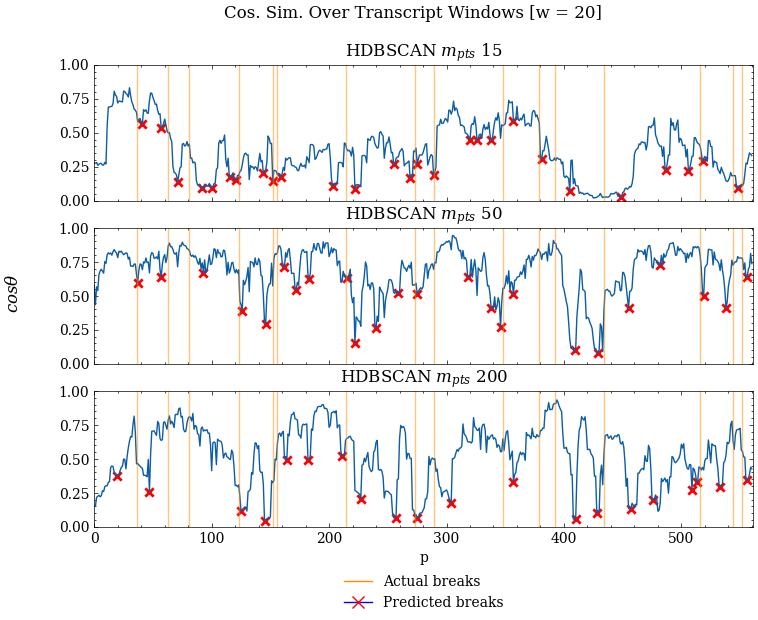

In [7]:
# Analyse same transcript over all cluster models
sent_proba15 = np.load('../Thesis/annotated_probabilities_msize15/proba_dens_vec_msize15_0ZGQ63222rqX5TD5ZrMmcN.npy')
sent_proba50 = np.load('../Thesis/annotated_probabilities_msize50/proba_dens_vec_msize50_0ZGQ63222rqX5TD5ZrMmcN.npy')
sent_proba200 = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')
print(sent_proba200.shape)

# make dataframe for processing and get properties
pipeline_df15 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba15))], "topic_probs": sent_proba15.tolist()})
pipeline_df50 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba50))], "topic_probs": sent_proba50.tolist()})
pipeline_df200 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba200))], "topic_probs": sent_proba200.tolist()})

smooth15 = smoothing(pipeline_df15, threshold=1e-20)
smooth50 = smoothing(pipeline_df50, threshold=1e-20)
smooth200 = smoothing(pipeline_df200, threshold=1e-20)

win = 20
cos_sims15 = window_cosine_sim(smooth15, window_size=win)
cos_sims50 = window_cosine_sim(smooth50, window_size=win)
cos_sims200 = window_cosine_sim(smooth200, window_size=win)

bounds15 = segmentation_main_call(pipeline_df15, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np15 = np.array(bounds15) - win
bounds50 = segmentation_main_call(pipeline_df50, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np50 = np.array(bounds50) - win
bounds200 = segmentation_main_call(pipeline_df200, print_state_min=False, print_state_depth=False, window=win, height=0.95)
boundaries_np200 = np.array(bounds200) - win

# get actual breaks
actual = pd.read_pickle('annotations.pkl')
actual_bounds_for_plotting = actual[actual.episode_id=='0ZGQ63222rqX5TD5ZrMmcN'].iloc[0,2]
actual_bounds_for_plotting_np = np.array(actual_bounds_for_plotting) - win*2  # compensate for position

# plot same transcript over all cluster models
plt.style.use(['science','no-latex'])
fig, axs = plt.subplots(3,1, figsize=(8.5, 6), sharey=True, sharex=True)

sns.lineplot(cos_sims15, ax=axs[0])
sns.lineplot(cos_sims50, ax=axs[1])
sns.lineplot(cos_sims200, ax=axs[2])
sns.scatterplot(x= boundaries_np15, y=cos_sims15[boundaries_np15], marker="x", linewidth=2, color='r', ax=axs[0])
sns.scatterplot(x= boundaries_np50, y=cos_sims50[boundaries_np50], marker="x", linewidth=2, color='r', ax=axs[1])
sns.scatterplot(x= boundaries_np200, y=cos_sims200[boundaries_np200], marker="x", linewidth=2, color='r', ax=axs[2])
for line in actual_bounds_for_plotting_np:
    axs[0].axvline(line, color='darkorange', alpha=0.5)
    axs[1].axvline(line, color='darkorange', alpha=0.5)
    axs[2].axvline(line, color='darkorange', alpha=0.5)

axs[0].set_title('HDBSCAN $m_{pts}$ 15')
axs[1].set_title('HDBSCAN $m_{pts}$ 50')
axs[2].set_title('HDBSCAN $m_{pts}$ 200')

axs[0].set_ylim(bottom=0, top=1)
axs[0].set_xlim(left=0, right=len(cos_sims15))
axs[2].set_xlabel("p")

# Add custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='darkorange', lw=1, label='Actual breaks'),
                   Line2D([0], [0], marker='x', color='blue', label='Predicted breaks', markersize=9, markerfacecolor='red', markeredgecolor='red')]
axs[2].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.7))

fig.supylabel(r"$cos \theta$")
fig.suptitle(f"Cos. Sim. Over Transcript Windows [w = {win}]")

plt.show()

In [17]:
# Investigate cosine similarity differences and average depth scores accross models for the transcript in plot above
print(f'15 Cosine sim range: {max(cos_sims15)-min(cos_sims15):.3f}')
print(f'50 Cosine sim range: {max(cos_sims50)-min(cos_sims50):.3f}')
print(f'200 Cosine sim range: {max(cos_sims200)-min(cos_sims200):.3f}')
print()

ds_15 = temp_depth_scores = get_depth_scores(pipeline_df15, print_state_min=False)
ds_50 = temp_depth_scores = get_depth_scores(pipeline_df50, print_state_min=False)
ds_200 = temp_depth_scores = get_depth_scores(pipeline_df200, print_state_min=False)

print('15 avg depth score:', round(np.mean(ds_15), 3))
print('50 avg depth score:', round(np.mean(ds_50), 3))
print('200 avg depth score:', round(np.mean(ds_200), 3))
print()

print('15 utilisation of range: ', round(np.mean(ds_15)/ (max(cos_sims15)-min(cos_sims15)), 3))
print('50 utilisation of range: ', round(np.mean(ds_50)/ (max(cos_sims50)-min(cos_sims50)), 3))
print('200 utilisation of range: ', round(np.mean(ds_200)/ (max(cos_sims200)-min(cos_sims200)), 3))

15 Cosine sim range: 0.811
50 Cosine sim range: 0.862
200 Cosine sim range: 0.888

15 avg depth score: 0.339
50 avg depth score: 0.487
200 avg depth score: 0.431

15 utilisation of range:  0.418
50 utilisation of range:  0.566
200 utilisation of range:  0.485


In [37]:
# get WD scores for the example above
actual = pd.read_pickle('annotations.pkl')
actual_bounds = actual[actual.episode_id == '0ZGQ63222rqX5TD5ZrMmcN'].iloc[0,2]
actual_bounds_set = set(actual_bounds)

predicted_bounds = segmentation_main_call(pipeline_df50, print_state_min=False, print_state_depth=False, window=20, height=0.95)
predicted_bounds_set = set(predicted_bounds)

window_diff_ls_50 = []
vector_length = len(sent_proba50)
k = 4
window_diff_unnormalised = 0
for i in range(vector_length - k):
    sliding_window = set([w for w in range(i, i + k, 1)])
    actual_in_sliding_window = len(actual_bounds_set.intersection(sliding_window)) # ref
    predicted_in_sliding_window = len(predicted_bounds_set.intersection(sliding_window)) # hyp
    window_diff_absolute = np.abs(actual_in_sliding_window - predicted_in_sliding_window)
    window_diff_unnormalised += window_diff_absolute
window_diff = (1/(vector_length-k)) * window_diff_unnormalised
window_diff_ls_50.append(window_diff)

In [38]:
print(window_diff_ls_15)
print(window_diff_ls_50)
print(window_diff_ls_200)

[0.2646566164154104]
[0.22780569514237856]
[0.22780569514237856]


### Model effect of dimensionality on cosine similarity (depth scores)

In [4]:
# Get cosine ranges of all annotated transcripts

transcript_list = ['13NDTKL5ZGs8cb8dojW3bz', '6preEOWrgR9eRr938upFgv',
       '2Bp5vd9GAmEpZzjEtGQBFD', '0ZGQ63222rqX5TD5ZrMmcN',
       '19W5dgUcFseQZBmcVF4coc', '3iydyD9rAb1f6rmvmgpwS4',
       '0bXWB28GwN8OiqC1ykRrRX', '28IWswylk2FvkebOehoCkL',
       '3DR5Qa40Mc17AiBYfmC29U', '3RT2j2BG8ILNYKjxsNhfvZ',
       '3p9FLEH5V5sCGHhGubaYZc', '5Sg6efUjypR4m6p9eYBXpm',
       '4y67J0Fmgm5L7TPPsUunwo', '1VBbCB6ja5pPdU2wrBy27N',
       '7A7swZJL0AtFghauiGLadV', '4pFaG2QLnDr95gqDQFEWoh',
       '53DrbE5nPJskpPT0PtOi9O', '5ts4p0QlyePWCgIB2W1wLf',
       '7mv5E2yb2yVQU34OiQ1vqv', '4DUIcbw3EZpeYUC2mcxV0D']

min_max_15 = []
min_max_50 = []
min_max_200 = []

for transcript in transcript_list:
    # Analyse same transcript over all cluster models
    sent_proba15 = np.load(f'../Thesis/annotated_probabilities_msize15/proba_dens_vec_msize15_{transcript}.npy')
    sent_proba50 = np.load(f'../Thesis/annotated_probabilities_msize50/proba_dens_vec_msize50_{transcript}.npy')
    sent_proba200 = np.load(f'../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_{transcript}.npy')
    # print(sent_proba200.shape)

    # make dataframe for processing and get properties
    pipeline_df15 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba15))], "topic_probs": sent_proba15.tolist()})
    pipeline_df50 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba50))], "topic_probs": sent_proba50.tolist()})
    pipeline_df200 = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba200))], "topic_probs": sent_proba200.tolist()})

    smooth15 = smoothing(pipeline_df15, threshold=1e-20)
    smooth50 = smoothing(pipeline_df50, threshold=1e-20)
    smooth200 = smoothing(pipeline_df200, threshold=1e-20)

    win = 20
    cos_sims15 = window_cosine_sim(smooth15, window_size=win)
    cos_sims50 = window_cosine_sim(smooth50, window_size=win)
    cos_sims200 = window_cosine_sim(smooth200, window_size=win)

    min_max_15.append([min(cos_sims15), max(cos_sims15)])
    min_max_50.append([min(cos_sims50), max(cos_sims50)])
    min_max_200.append([min(cos_sims200), max(cos_sims200)])

min_max_15 = np.array(min_max_15)
min_max_50 = np.array(min_max_50)
min_max_200 = np.array(min_max_200)

print(f'15 diff {np.mean(min_max_15[:,1]) - np.mean(min_max_15[:,0])}')
print(f'50 diff {np.mean(min_max_50[:,1]) - np.mean(min_max_50[:,0])}')
print(f'200 diff {np.mean(min_max_200[:,1]) - np.mean(min_max_200[:,0])}')

15 diff 0.7137061241240844
50 diff 0.7197710469956391
200 diff 0.664412618985788


In [55]:
# test the significance of the differences (long shot)
from scipy.stats import ttest_ind, ttest_rel

diff_15 = min_max_15[:,1] - min_max_15[:,0]
diff_50 = min_max_50[:,1] - min_max_50[:,0]
diff_200 = min_max_200[:,1] - min_max_200[:,0]

print('independent 15 vs 50', ttest_ind(diff_15, diff_50))
print('independent 15 vs 200', ttest_ind(diff_15, diff_200))
print('independent 50 vs 200', ttest_ind(diff_50, diff_200))
print('paired 15 vs 50', ttest_rel(diff_15, diff_50))
print('paired 15 vs 200', ttest_rel(diff_15, diff_200))
print('paired 50 vs 200', ttest_rel(diff_50, diff_200))

independent 15 vs 50 Ttest_indResult(statistic=-0.09631745752954461, pvalue=0.9237746333842229)
independent 15 vs 200 Ttest_indResult(statistic=0.6874473214574983, pvalue=0.49597556492051387)
independent 50 vs 200 Ttest_indResult(statistic=0.7867510981493239, pvalue=0.4363069354038559)
paired 15 vs 50 TtestResult(statistic=-0.14593095723929292, pvalue=0.8855130161659901, df=19)
paired 15 vs 200 TtestResult(statistic=1.7391679418661252, pvalue=0.09818185951663558, df=19)
paired 50 vs 200 TtestResult(statistic=1.1162324148612959, pvalue=0.2782410669796058, df=19)


In [71]:
model_list = [15,50,200]
transcript_list = ['13NDTKL5ZGs8cb8dojW3bz', '6preEOWrgR9eRr938upFgv',
       '2Bp5vd9GAmEpZzjEtGQBFD', '0ZGQ63222rqX5TD5ZrMmcN',
       '19W5dgUcFseQZBmcVF4coc', '3iydyD9rAb1f6rmvmgpwS4',
       '0bXWB28GwN8OiqC1ykRrRX', '28IWswylk2FvkebOehoCkL',
       '3DR5Qa40Mc17AiBYfmC29U', '3RT2j2BG8ILNYKjxsNhfvZ',
       '3p9FLEH5V5sCGHhGubaYZc', '5Sg6efUjypR4m6p9eYBXpm',
       '4y67J0Fmgm5L7TPPsUunwo', '1VBbCB6ja5pPdU2wrBy27N',
       '7A7swZJL0AtFghauiGLadV', '4pFaG2QLnDr95gqDQFEWoh',
       '53DrbE5nPJskpPT0PtOi9O', '5ts4p0QlyePWCgIB2W1wLf',
       '7mv5E2yb2yVQU34OiQ1vqv', '4DUIcbw3EZpeYUC2mcxV0D']

depth_scores_df = pd.DataFrame(columns=['mpts', 'depth_score'])


mpts15 = []
mpts50 = []
mpts200 = []

for model in model_list:
    for tran in transcript_list:
        # load data
        prob_dens_vec = np.load(f'../Thesis/annotated_probabilities_msize{model}/proba_dens_vec_msize{model}_{tran}.npy')
        temp_df = pd.DataFrame({"sentence_no":[i for i in range(len(prob_dens_vec))], "topic_probs": prob_dens_vec.tolist()})
        # get depth scores and append to df
        temp_depth_scores = get_depth_scores(temp_df, print_state_min=False)
        temp_model_mpts = [int(model)] * len(temp_depth_scores)
        output = pd.DataFrame({'mpts': temp_model_mpts, 'depth_score': temp_depth_scores})
        depth_scores_df = pd.concat([depth_scores_df, output])
        if model ==15: 
            mpts15.append(np.mean(temp_depth_scores))
        elif model == 50:
            mpts50.append(np.mean(temp_depth_scores))
        else:
            mpts200.append(np.mean(temp_depth_scores))

avg_ds_per_transcript = pd.DataFrame({'episode_id': transcript_list, 'mpts15': mpts15, 'mpts50': mpts50, 'mpts200': mpts200})
depth_scores_df = depth_scores_df.reset_index(drop=True)
print(avg_ds_per_transcript.shape)
depth_scores_df.shape

(20, 4)


(2009, 2)

          mean    median       min       max  count
mpts                                               
15    0.455647  0.452917  0.000487  0.999168    658
50    0.551327  0.551765  0.002003  0.998606    657
200   0.447608  0.456248  0.019596  0.987985    694


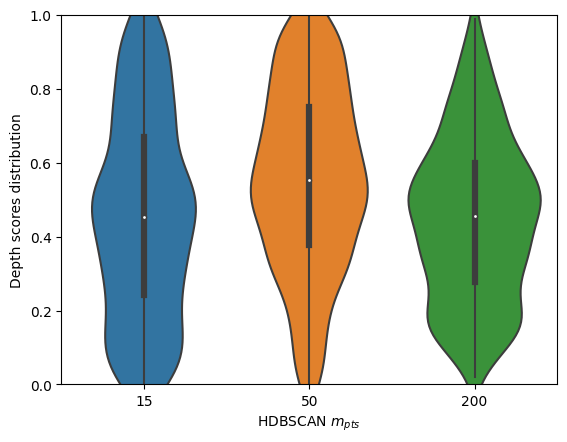

LIN REG: 
R-squared: -0.0771 
Slope coef.: -0.00023943 
p-value: 0.0005445627086911248 
Intercept: 1


In [69]:
from scipy import stats
print(depth_scores_df.groupby('mpts')['depth_score'].agg(['mean', 'median','min', 'max', 'count']))

sns.violinplot(data=depth_scores_df, x='mpts', y='depth_score')
plt.xlabel('HDBSCAN $m_{pts}$')
plt.ylabel('Depth scores distribution')
plt.ylim(bottom=0, top=1)
plt.show()

lin_reg = stats.linregress(x = depth_scores_df.mpts.astype(float), y= depth_scores_df.depth_score)
print(f"LIN REG: \nR-squared: {round(lin_reg.rvalue, 4)} \nSlope coef.: {round(lin_reg.slope, 8)} \np-value: {lin_reg.pvalue} \nIntercept: {round(lin_reg.intercept)}")

In [62]:
# test the significance between means of the depth scores for different models (long shot)
print('independent 15 vs 50', ttest_ind(depth_scores_df[depth_scores_df.mpts==15].depth_score, depth_scores_df[depth_scores_df.mpts==50].depth_score))
print('independent 15 vs 200', ttest_ind(depth_scores_df[depth_scores_df.mpts==15].depth_score, depth_scores_df[depth_scores_df.mpts==200].depth_score))
print('independent 50 vs 200', ttest_ind(depth_scores_df[depth_scores_df.mpts==50].depth_score, depth_scores_df[depth_scores_df.mpts==200].depth_score))

independent 15 vs 50 Ttest_indResult(statistic=-6.657447625494311, pvalue=4.083482441212937e-11)
independent 15 vs 200 Ttest_indResult(statistic=0.5977203062867005, pvalue=0.5501268217444433)
independent 50 vs 200 Ttest_indResult(statistic=8.175455893557956, pvalue=6.72946754249813e-16)


In [82]:
print(np.mean(avg_ds_per_transcript.mpts15))
print(np.mean(avg_ds_per_transcript.mpts50))
print(np.mean(avg_ds_per_transcript.mpts200))
print('independent 15 vs 50', ttest_ind(avg_ds_per_transcript.mpts15, avg_ds_per_transcript.mpts50))
print('independent 15 vs 200', ttest_ind(avg_ds_per_transcript.mpts15, avg_ds_per_transcript.mpts200))
print('independent 50 vs 200', ttest_ind(avg_ds_per_transcript.mpts50, avg_ds_per_transcript.mpts200))

0.449739820450538
0.5581032721408794
0.4249030763685663
independent 15 vs 50 Ttest_indResult(statistic=-2.820374733230035, pvalue=0.007582126374913093)
independent 15 vs 200 Ttest_indResult(statistic=0.6315396133194044, pvalue=0.5314687560002946)
independent 50 vs 200 Ttest_indResult(statistic=3.930775729178135, pvalue=0.0003465830081472081)


### More visulaisations

Window size: 20, segments: 20


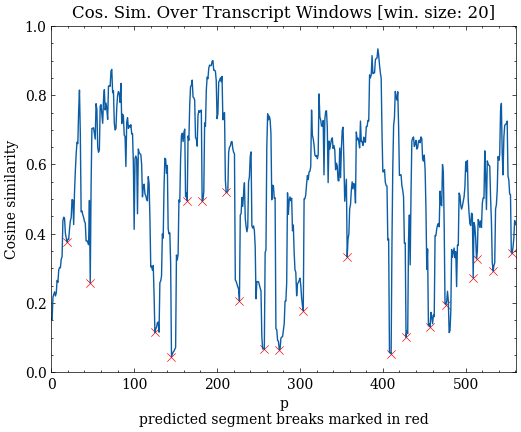

In [186]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize200/proba_dens_vec_msize200_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

(601, 555)
Window size: 20, segments: 24


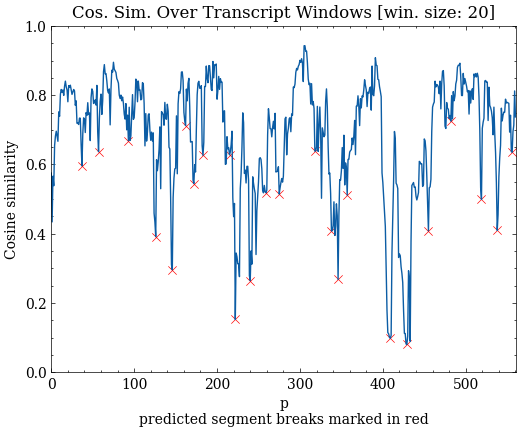

In [191]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize50/proba_dens_vec_msiz500ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

(601, 2880)
Window size: 20, segments: 27


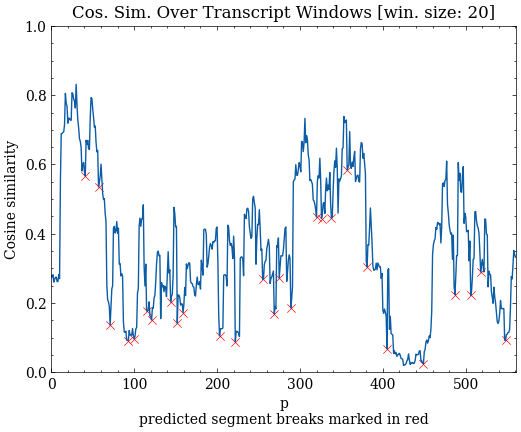

In [188]:
# Plot and analyse with different size windows
sent_proba = np.load('../Thesis/annotated_probabilities_msize15/proba_dens_vec_msize15_0ZGQ63222rqX5TD5ZrMmcN.npy')  #../Thesis/probabilities.npy window size 34
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
windows = [i for i in range(20, 21, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

## Testing with synthetic data

### Generate synthetic data

In [3]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


### Testing

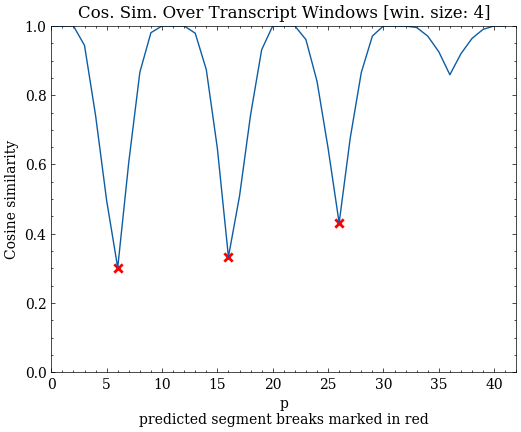

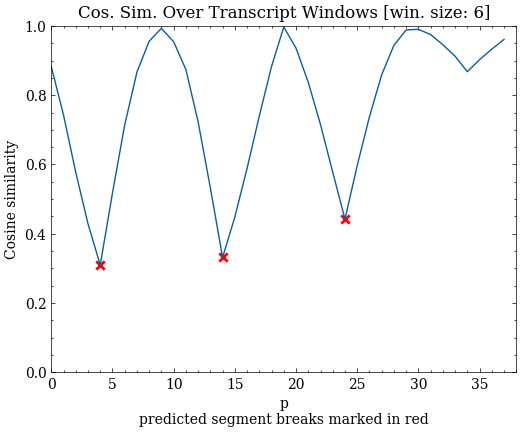

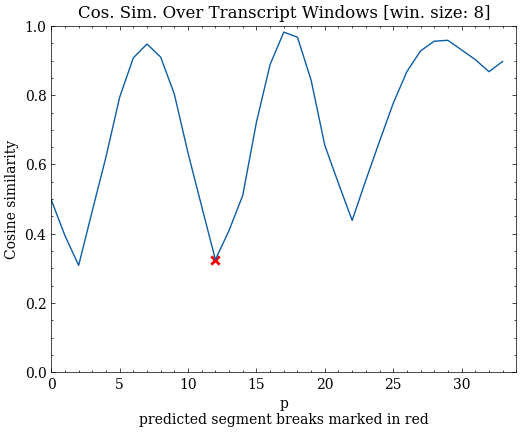

In [4]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(4, 9, 2)]

for window in windows_ls:
    bounds_testing = segmentation_main_call(testing_df, print_state_min=False, print_state_depth=False, window=window, height=0.95)
    con_sim = window_cosine_sim(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window, boundaries=bounds_testing)
    print()

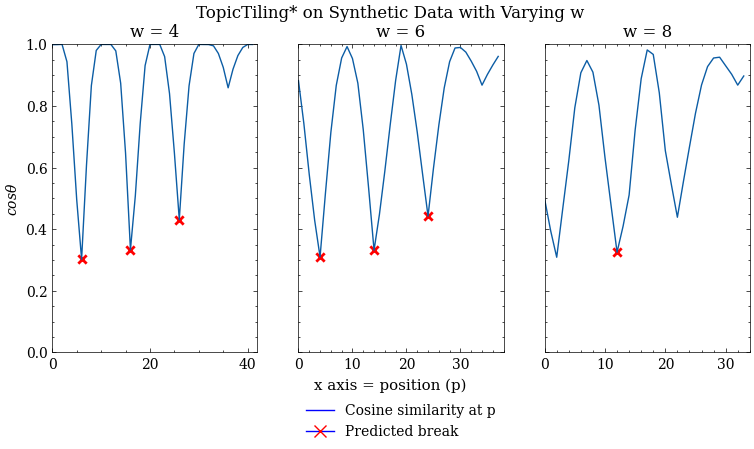

In [51]:
plt.style.use(['science','no-latex'])
fig, axs = plt.subplots(1,3, figsize=(9,4), sharey=True)

for i in range(0,3):
    bounds_testing = segmentation_main_call(testing_df, print_state_min=False, print_state_depth=False, window=(4+i*2), height=0.95)
    con_sim = window_cosine_sim(testing_df, window_size = (4+i*2)) 
    boundaries_np = np.array(bounds_testing) - (4+i*2)


    sns.lineplot(con_sim, ax=axs[i])
    sns.scatterplot(x=boundaries_np, y=con_sim[boundaries_np], marker="x", linewidth=2, color='r', ax=axs[i])
    axs[i].set_ylim(bottom=0, top=1)
    axs[i].set_xlim(left=0, right=len(con_sim))
    axs[i].set_ylabel(r"$cos \theta$")
    axs[i].set_title(f"w = {4+i*2}")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=1, label='Cosine similarity at p'),
                   Line2D([0], [0], color='blue', marker='x', label='Predicted break', markersize=9, markerfacecolor='red', markeredgecolor='red')]
axs[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.32))

plt.rcParams.update({'font.size': 9})  # return to normal font size
fig.supxlabel("x axis = position (p)")
plt.rcParams.update({'font.size': 10})  # return to normal font size
fig.suptitle(f"TopicTiling* on Synthetic Data with Varying w")
plt.show()